# Activity 11.01 - Multiple regression with nonlinear models

As part of a research effort to improve metallic-oxide semiconductor sensors for the toxic gas carbon monoxide (CO), you are asked to investigate models of the sensor response from an array of sensors. You will review the data, perform some feature engineering for an array of sensors. You will review the data, perform some feature engineering for non-linear features, and then compare a baseline linear regression approach to a random forest model:

1. For this exercise, you will need the pandas and numpy libraries, and three modules from sklearn, matplotlib, and seaborn. Load them in the first cell of the notebook:

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as OLS
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

2. As we have done before, create a utility function to plot a grid of histograms after being given the data, which variables to plot, the rows and columns of the grid, and how many bins. Similarly, create a utility function that allows you to plot a list of variables as scatter plots against a given x variable, also after being given the rows and columns of the grid.

In [2]:
#
# utility function for plotting histograms in a grid
#
def plot_histogram_grid(df, variables, n_rows, n_cols, bins):
    fig = plt.figure(figsize = (8, 7))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
#
# for some variables there are relatively few unique values, so we'll
# adjust the histogram appearance accordingly to avoid "gaps" in the plots
#    
        if len(np.unique(df[var_name])) <= bins:
          use_bins = len(np.unique(df[var_name]))
        else:
          use_bins = bins
#      
        df[var_name].hist(bins = use_bins, ax = ax)
        ax.set_title(var_name, fontsize = 10)
    fig.tight_layout()
    plt.show()
#
# utility function for plotting scatterplots in a grid
#
def plot_scatter_grid(df, y_cols, x_var, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize = (8, 7))
    fig.tight_layout(pad = 2)
    for row in range(rows):
        for col in range(cols):
            if (row * (cols - 1) + col) <= (len(y_cols) - 1):
                plot_col = y_cols[row * (cols - 1) + col]
                ax[row, col].scatter(my_data[x_var], 
                                     my_data.loc[:, plot_col],
                                     marker = 'o', s = 5, 
                                     linewidths = 0.1, 
                                     alpha = 0.65, 
                                     facecolor = None)
                ax[row, col].set_title(plot_col + ' vs. ' + x_var,
                                      fontsize = 10)
            else:
                fig.delaxes(ax[row, col])
    plt.show()

3. Now, load the CO_sensors.csv file into a DataFrame called my_data. Show first 5 rows.

In [3]:
my_data=pd.read_csv('Chapter11-Datasets/CO_sensors.csv')
my_data.head(5)

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
0,0.000,0.0,49.21,26.38,247.2771,0.1994,0.5114,0.5863,0.5716,1.9386,1.1669,0.7103,0.5541,51.0146,40.8079,47.8748,4.6007,1.0259,0.6300,0.4302
1,0.311,0.0,49.21,26.38,243.3618,0.7158,0.0626,0.1586,0.1161,0.1347,0.1385,0.1545,0.1307,0.1935,0.1341,0.1773,0.1403,0.1399,0.1243,0.1236
2,0.620,0.0,49.21,26.38,242.4944,0.8840,0.0654,0.1496,0.1075,0.1076,0.1131,0.1363,0.1188,0.1195,0.1049,0.1289,0.1189,0.1216,0.1106,0.1130
3,0.930,0.0,49.21,26.38,241.6242,0.8932,0.0722,0.1444,0.1074,0.1032,0.1106,0.1306,0.1190,0.1125,0.1014,0.1232,0.1153,0.1185,0.1091,0.1114
4,1.238,0.0,49.21,26.38,240.8151,0.8974,0.0767,0.1417,0.1098,0.1025,0.1116,0.1284,0.1208,0.1111,0.1008,0.1226,0.1140,0.1175,0.1090,0.1111


4. Use .describe().T to inspect the data further

In [4]:
my_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time (s),295700.0,45435.140266,26245.705362,0.0000,22696.21350,45430.5430,68165.08150,90901.7260
CO (ppm),295700.0,9.900266,6.426957,0.0000,4.44000,8.8900,15.56000,20.0000
Humidity (%r.h.),295700.0,45.607506,12.445601,16.4300,36.14000,46.7000,55.37000,72.9800
Temperature (C),295700.0,26.720057,0.418020,25.3800,26.38000,26.6600,27.06000,27.4200
Flow rate (mL/min),295700.0,239.943680,1.697848,0.0000,239.90420,239.9716,240.03660,262.3167
Heater voltage (V),295700.0,0.355212,0.288572,0.1990,0.20000,0.2000,0.20700,0.9010
R1 (MOhm),295700.0,15.198374,22.583110,0.0324,0.40480,1.7121,25.85040,119.5851
R2 (MOhm),295700.0,17.440031,26.665302,0.0555,0.48140,1.3664,29.05830,142.5199
R3 (MOhm),295700.0,22.151461,28.585001,0.0541,0.57940,4.0667,44.88580,127.2483
R4 (MOhm),295700.0,19.759571,16.412620,0.0394,1.94360,19.9434,31.75500,78.4601


5. Use the histogram grid utility function to plot histograms of all columns, except Time(s).

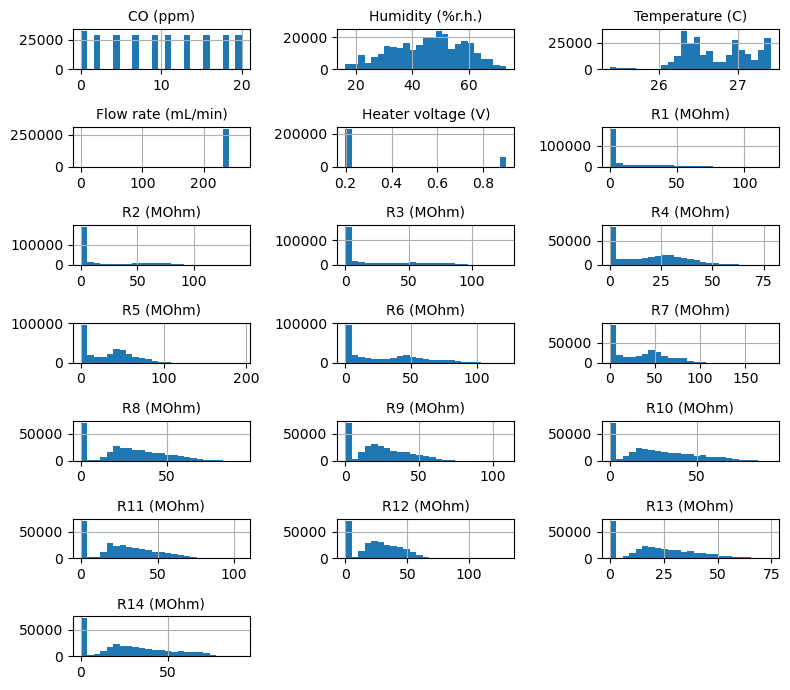

In [5]:
plot_histogram_grid(my_data, my_data.columns[1:],7,3,25)

6. Use seaborn to generate a pairplot of the first five columns (excluding the sensor readings).

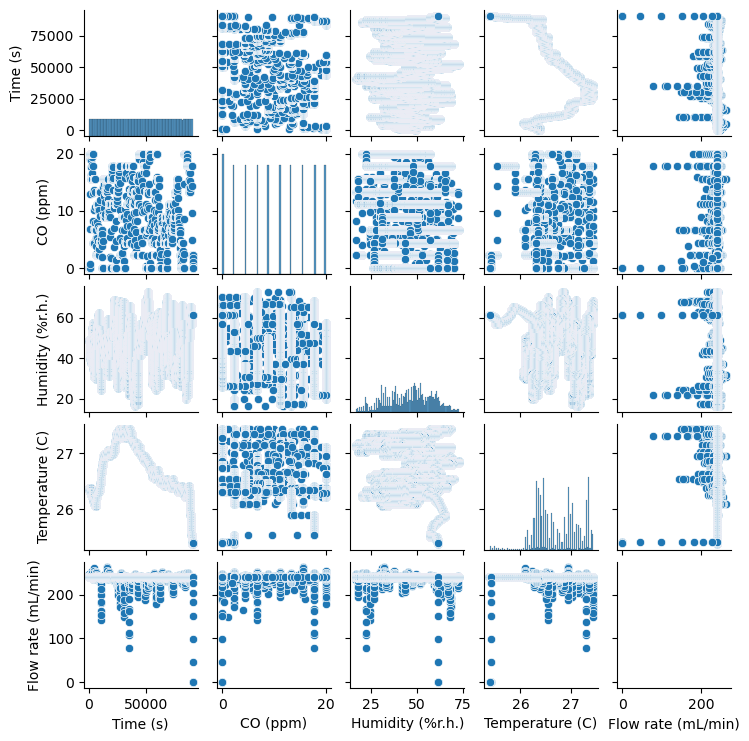

In [17]:
sns.pairplot(my_data.iloc[:, :5], height = 1.5, aspect = 1)

7. Use the scatter plot grid utility function to plot all the sensor data versus time.

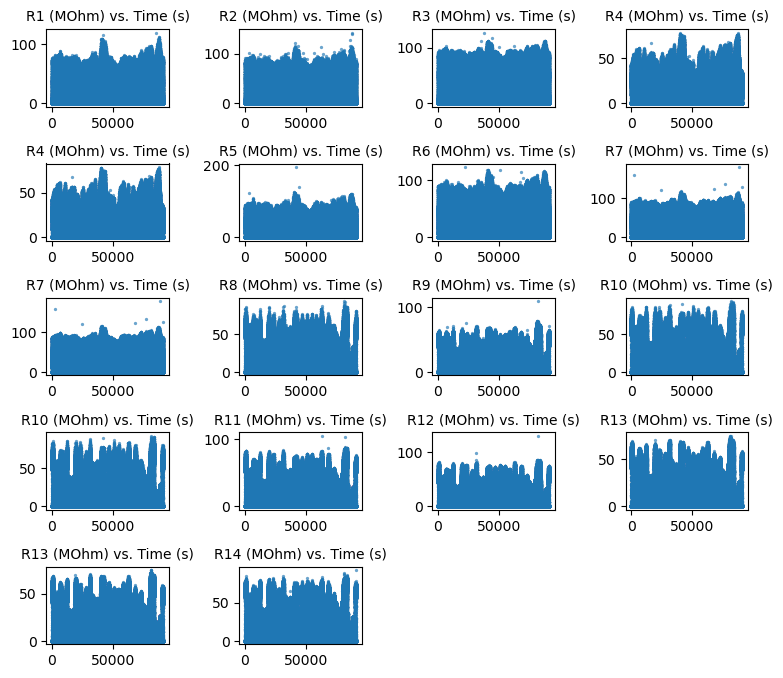

In [7]:
plot_cols = list(my_data.loc[:, 'R1 (MOhm)': ].columns)
plot_scatter_grid(my_data, plot_cols, 'Time (s)', 5, 4)

8. It's difficult to tell whether there is a time dependency or a periodic component. Zoom in on R13 over the time from 40000 to 45000 seconds.

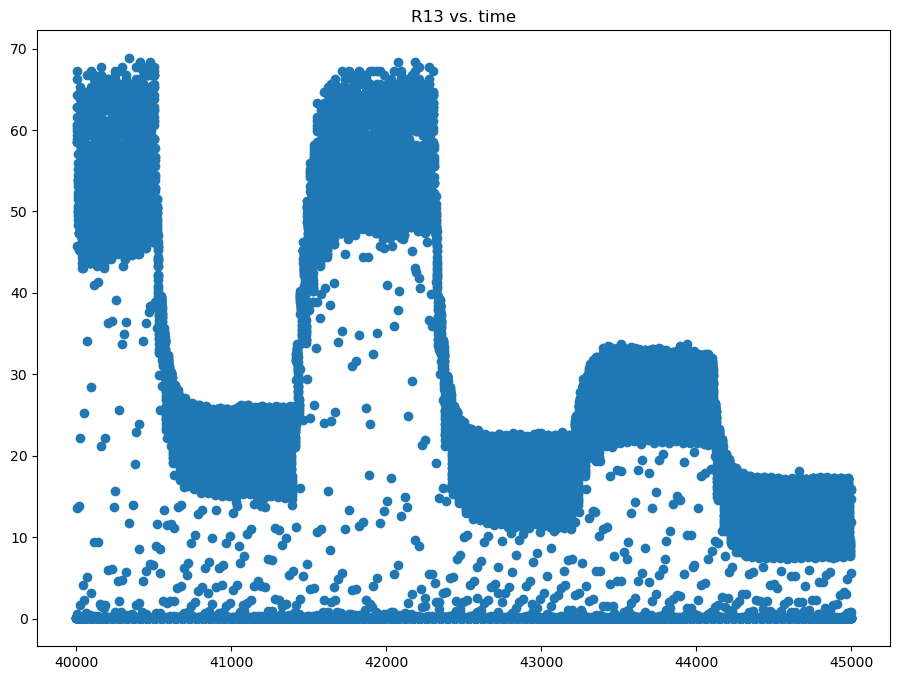

In [8]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.scatter(my_data.loc[(my_data['Time (s)'] > 40000) &
                      (my_data['Time (s)'] < 45000), 'Time (s)'],
          my_data.loc[(my_data['Time (s)'] > 40000) &
                      (my_data['Time (s)'] < 45000), 'R13 (MOhm)'])
ax.set_title('R13 vs. time')
plt.show()

You can now see that the tests appear to comprise step functions of various sizes. This shows that the time variable is arbitrary and not useful for modeling the CO response. We can also see that there are a significant number of values that deviate from the steps, which may be due to the humidity variations, measurement errors, or some other issues. These may limit how well we can model the results.

9. Investigate the relationship of the changes in R13 with the CO and Humidity values during one step change - for example, from about 41250 to 42500. Plot the R13 values using the .plot() method in matplotlib, and overlay the CO and Humidity values as line plots on the same plot.

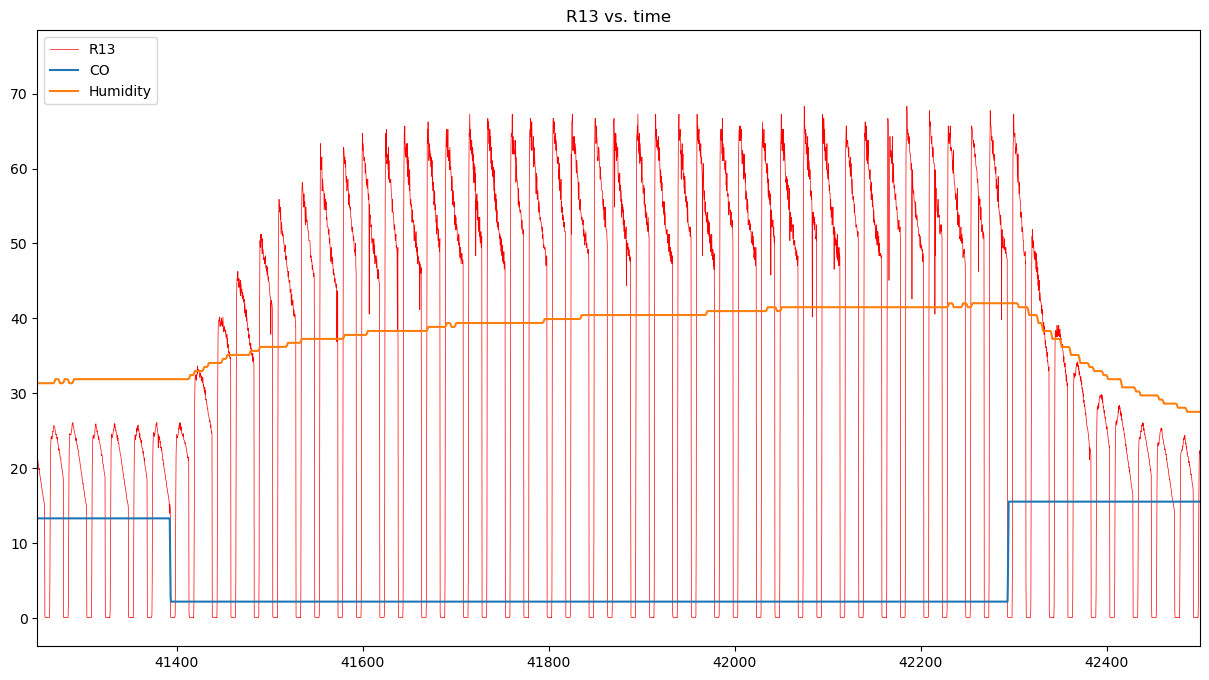

In [9]:
fig, ax = plt.subplots(figsize = (15, 8))
ax.plot(my_data['Time (s)'],
           my_data['R13 (MOhm)'],
           color = 'red', lw = 0.5, 
           label = 'R13')
ax.plot(my_data['Time (s)'],
           my_data['CO (ppm)'],
           label = 'CO')
ax.plot(my_data['Time (s)'],
           my_data['Humidity (%r.h.)'],
           label = 'Humidity')
ax.set_title('R13 vs. time')
ax.legend(loc = 'upper left', markerscale = 2)
ax.set_xlim((41250, 42500))
plt.show()

As you saw in the detail, there are a series of step changes for both CO and Humidity, resulting in changes in the resistance values. However, there are evident time lags involved, as shown by the curved traces of Humidity. In addition, R13 seems to spike, then fall, and have intervening periods where the values appears to be 0 and at a steady state. Perhaps this is a function of the electronics, but further investigation would be required to be sure.

10. Now, use seaborn to plot a correlation heatmap for the sensor columns.

<AxesSubplot:>

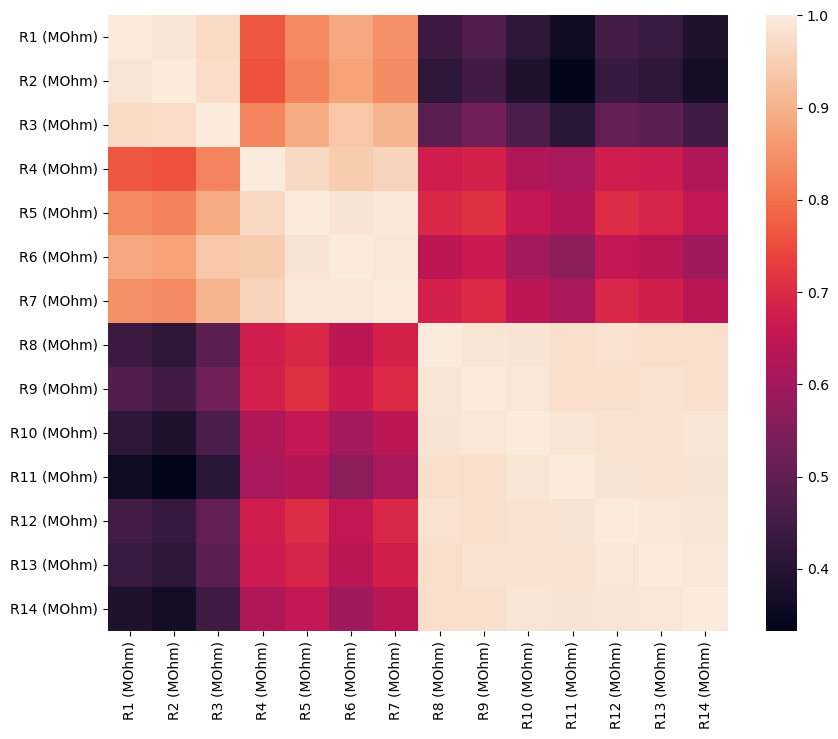

In [10]:
plt.figure(figsize = (10, 8))
sns.heatmap(my_data.loc[:, 'R1 (MOhm)':].corr())

Note that there are two or three groups in the plot. The last seven sensors are all highly correlated with one another. The first three are as well, as are the next four.

11. The data description for this data, says that there are two kinds of sensors: "Figaro Engineering (7 units of TGS 3870-A04) and FIS (7 units of SB-500-12)". Now, it is apparent that R1 to R7 are one kind of sensor and R8 to R14 are the other kind. The data was collected to evaluate the performance of the senors measuring CO at various conditions of temperature and humidity. In particular, the humidity is taken to be an "uncontrolled variable", and during tests, random levels of humidity were imposed. In the field, the humidity would not be controlled or measured, which impacts the interpretation of data, especially for low levels of CO. The sensors output is reported as resistance in MOhms, which are the main independent variables with which to predict CO. Temperature and the voltage applied to the sensor heater are also available.

Investigate the behavior of the sensors versus CO and humidity. Use the pandas .corr() method to generate the correlation matrix, and then use the first two rows of the result to make a barplot of the sensors correlations versus CO and Humidity respectively.

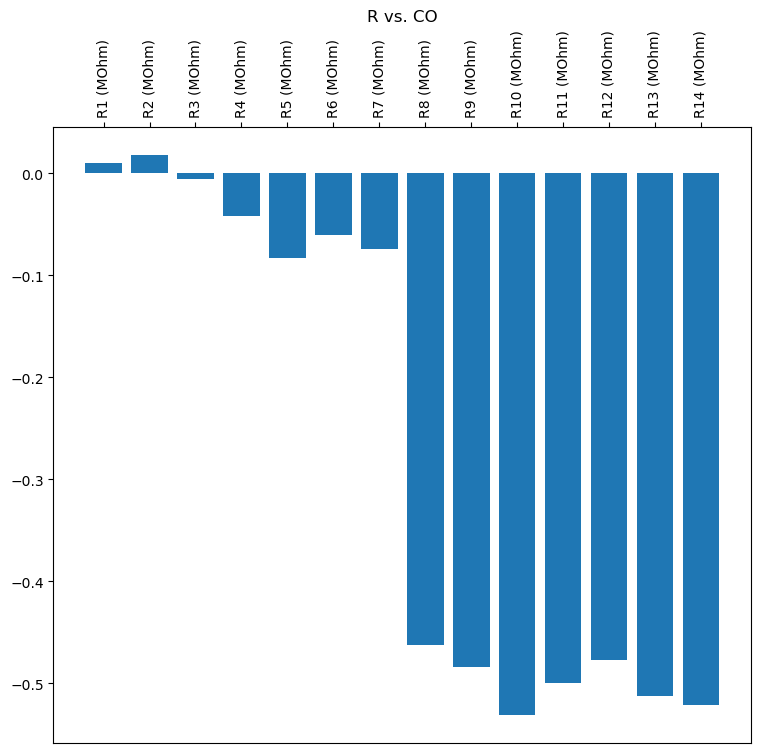

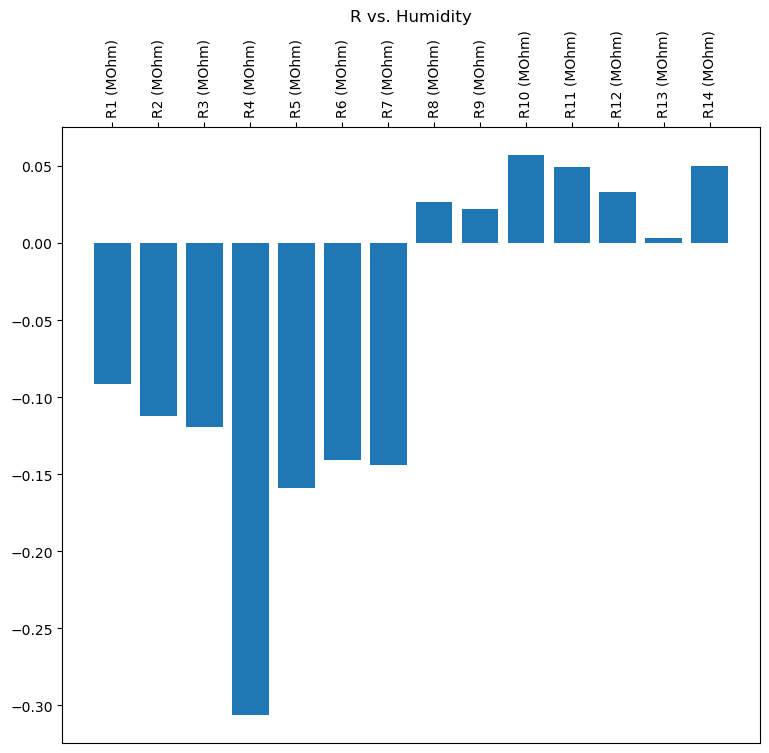

In [11]:
#
# we see two or three groups in the sensor correlations
#
# the data description 
# (https://archive.ics.uci.edu/ml/datasets/Gas+sensor+array+temperature+modulation)
# says there are two kinds of sensors:
# "(7 units of TGS 3870-A04) and FIS (7 units of SB-500-12)"
# 
# let's investigate the behavior of these vs. CO and humidity
#
Sensor_CO_corr = \
    (pd.concat([my_data.loc[:, ['CO (ppm)', 
                                'Humidity (%r.h.)']],
                my_data.loc[:, 'R1 (MOhm)':]], axis = 1).
     corr().loc['CO (ppm)':'Humidity (%r.h.)', 'R1 (MOhm)':])
#
# plot the CO correlations
#
fig, ax = plt.subplots(figsize = (9, 8))
ax.bar(x = Sensor_CO_corr.columns, height = Sensor_CO_corr.loc['CO (ppm)'])
ax.xaxis.set_ticks_position('top')
ax.set_title('R vs. CO')
plt.xticks(rotation = 90)
plt.show()
#
# plot the humidity correlations
#
fig, ax = plt.subplots(figsize = (9, 8))
ax.bar(x = Sensor_CO_corr.columns, height = Sensor_CO_corr.loc['Humidity (%r.h.)'])
ax.xaxis.set_ticks_position('top')
ax.set_title('R vs. Humidity')
plt.xticks(rotation = 90)
plt.show()

You see that while all the sensors are to measure the CO, they have markedly different behavior, depending on which of the two types we are measureing. From the problem description, it is evident that the sensors are impacted by humidity, but in the application, humidity is an uncontrolled and possibly unknown value. Hopefully, the different sensor behaviors can provide humidity information to a model and enable good predictions.

12. Apply a sqrt() transform to each of the sensor columns (since there are 0 or near-zero values, a log transform would not be appropriate) and add the columns to the dataset.

In [12]:
sensor_cols = list(my_data.loc[:, 'R1 (MOhm)': ].columns)
for i in range(len(sensor_cols)):
    my_data['sqrt_' + sensor_cols[i]] = np.sqrt(my_data[sensor_cols[i]])

13. For the initial model, drop Time, Humidity and CO from the X data. Use CO as the y data. Use Linear Regression to fit a model and plot the residuals, as well as the predicted versus actual values.

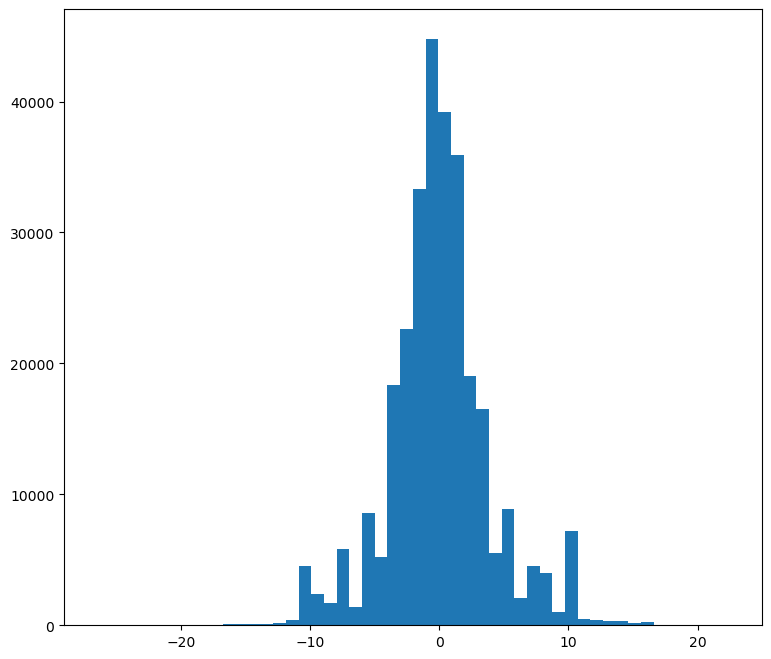

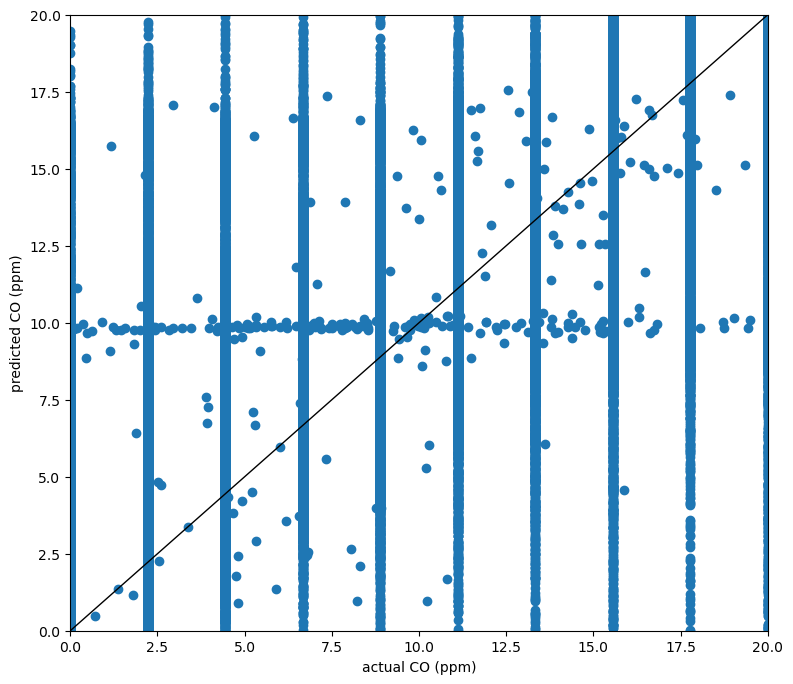

In [13]:
model_X = pd.concat([my_data.loc[:, 'Temperature (C)':'Heater voltage (V)'],
                     my_data.loc[:, 'sqrt_R1 (MOhm)':]], axis = 1)
model_y = my_data.loc[:, 'CO (ppm)']
my_model = OLS()
my_model.fit(model_X, model_y)
preds = my_model.predict(model_X)
residuals = preds - model_y
fig, ax = plt.subplots(figsize = (9, 8))
ax.hist(residuals, bins = 50)
plt.show()
#
fig, ax = plt.subplots(figsize = (9, 8))
ax.scatter(model_y, preds)
ax.plot([0, 20], [0, 20], color = 'black', lw = 1)
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_ylabel('predicted CO (ppm)')
ax.set_xlabel('actual CO (ppm)')
plt.show()

This model produces unbiased results, as shown by the residuals centered around 0, but from the second plot, we can see that there are multiple issues. There are groups of incorect predictions at various levels, along with a clump near the middle of the predicted CO readings of 10 ppm. This result clearly is not acceptable.

14. Scale the data with StandardScaler() and then fit a RandomForestRegressor() method to the model. Plot the residuals and the predicted versus actual values.

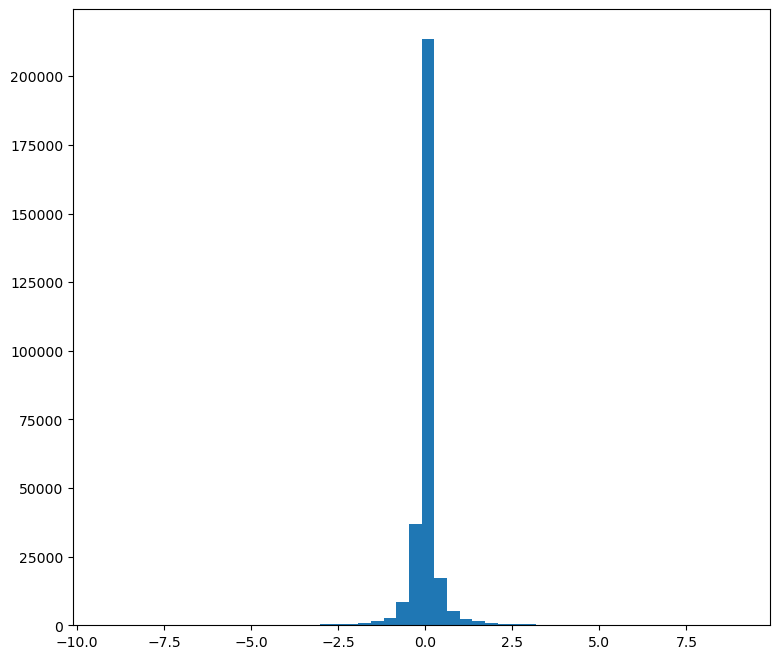

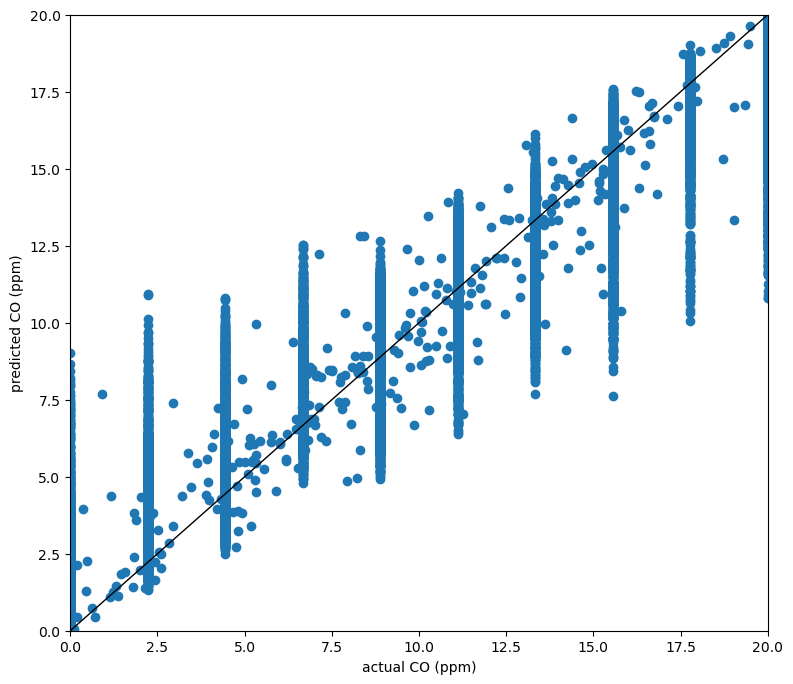

In [14]:
#
# scale the data
# 
scaler = StandardScaler()
model_X = scaler.fit_transform(model_X)
#
# fit a Random Forest model
#
RF_model = RandomForestRegressor(n_estimators = 100)
RF_model.fit(model_X, model_y)
#
# look at the residuals
#
preds = RF_model.predict(model_X)
residuals = preds - model_y
#
fig, ax = plt.subplots(figsize = (9, 8))
ax.hist(residuals, bins = 50)
plt.show()
#
# compare predicted to actual
#
fig, ax = plt.subplots(figsize = (9, 8))
ax.scatter(model_y, preds)
ax.plot([0, 20], [0, 20], color = 'black', lw = 1)
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_ylabel('predicted CO (ppm)')
ax.set_xlabel('actual CO (ppm)')
plt.show()

Although it is evident that the Random Forest model has reduced the residuals, the vertical groupings are still present, which is not a satisfactory result. Reviewing the figure, not that although the CO values are shown and nearly constant, there is a lag time in the humidity and sensor resistance values. A possible approach would be to average readings. A simple test of this idea is to group by the CO values and take the mean sensor values, and the model with those. In addition, it seems reasonable to filter out the regions where the resistance values drop to low values, as those seem anamolous.

15. Create a dataset, filtering out all the rows where a sensor resistance values drops to a low values, say 0.1. Then, group by CO(ppm) and aggregate as the mean values. Build a Random Forest model using the sensor mean resistances and the CO group values. Aso, refit a linear regression model to this data. Plot the predicted values versus the actual values for both results.

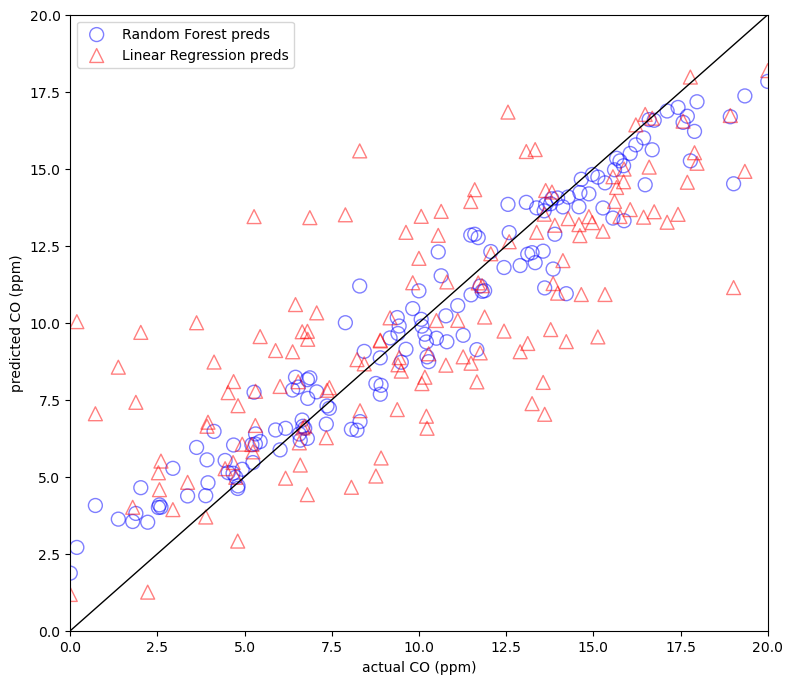

In [16]:
model_data = \
    my_data.loc[np.min(my_data.loc[:,'R1 (MOhm)':'sqrt_R14 (MOhm)'], 
                       axis = 1) > 0.1, :]
model_data = model_data.groupby('CO (ppm)').agg('mean')
model_X = model_data.loc[:, 'R1 (MOhm)':'sqrt_R14 (MOhm)']
model_y = model_data.index
lin_model = OLS()
lin_model.fit(model_X, model_y)
lin_preds = lin_model.predict(model_X)
RF_model = RandomForestRegressor(random_state = 42)
RF_model.fit(model_X, model_y)
RF_preds = RF_model.predict(model_X)
fig, ax = plt.subplots(figsize = (9, 8))
ax.scatter(model_y, RF_preds, 
           marker = 'o', s = 100,
           facecolor = 'None', color = 'blue', 
           alpha = 0.5,
           label = 'Random Forest preds')
ax.scatter(model_y, lin_preds, 
           marker = '^', s = 100, 
           facecolor = 'None', color = 'red', 
           alpha = 0.5,
           label = 'Linear Regression preds')
ax.plot([0, 20], [0, 20], color = 'black', lw = 1)
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_ylabel('predicted CO (ppm)')
ax.set_xlabel('actual CO (ppm)')
ax.legend(loc = 'upper left')
plt.show()

These results are much better. This would require more discussion with expert stakeholders to confirm this approach, but it is a promising direction to obtain a calibration for the sensors. Note that the linear regression model cannot fit a lot of the data nearly as well. Also, note that the vertical scatter in the Random Forest predictions might be an indicator of noise caused by the random humidity values. This can be investigated further by building another model including Humidity as an independent variable.